# HBURS: a Housing Bureaucrat Prediction AI
by Alessandro G. Magnasco, amagnasco@gradcenter.cuny.edu
for CUNY GC Data 712, Sum 2022

HBURS is a machine learning algorithm that uses a list of official violations of the NYC Housing Code to estimate which buildings would be eligible for the Alternative Enforcement Program, using the official selection list as training & test data.


#### The first version of this program will only use data from 2015, to make my life easier. The AEP start date will therefore be the following year.

Alternative Enforcement Program:
"Selection criteria for AEP include the number of class "B" hazardous and class "C" immediately hazardous housing maintenance code violations and the dollar value of emergency repair charges incurred as a result of the work performed by HPD. Failure to correct the qualifying conditions may result in emergency repair charges, liens, and significant fees. Only multiple dwellings are selected."
https://www1.nyc.gov/site/hpd/services-and-information/alternative-enforcement-program-aep.page

### Datasets:
all housing maintenance code violations
https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5

all open market orders for emergency repair
https://data.cityofnewyork.us/Housing-Development/Open-Market-Order-OMO-Charges/mdbu-nrqn

buildings selected for alternative enforcement
https://data.cityofnewyork.us/Housing-Development/Buildings-Selected-for-the-Alternative-Enforcement/hcir-3275

### Other enforcement programs not used in this version:

Underlying Conditions Program:
(This program was not used for the initial classifier because of the complexity of its requirements)
https://www1.nyc.gov/site/hpd/services-and-information/underlying-conditions-program-ll6.page |||| https://data.cityofnewyork.us/Housing-Development/Buildings-Selected-for-the-Underlying-Conditions-P/xpbf-ithr

Certificate Of No Harassment:
(This program was not used for the initial classifier to maintain simplicity)
https://data.cityofnewyork.us/Housing-Development/Certification-of-No-Harassment-CONH-Pilot-Building/bzxi-2tsw

In [44]:
## System imports

# system library
import os

# math & data operations libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

# machine learning libraries
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# charting library
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

## Step 0: merging+cleaning source data

### This entire section grabs several large datasets and merges them into one small tidy dataset used for Projects 1, 2, and 3. To avoid uploading several GB of data to Github, I wrapped them all into functions and commented out when I declared them.

In [45]:
## Classifier Factor One: Number of Class "B" and "C" housing maintenance code violations

viols_import = 0
def import_viols():
    global viols_import
    # list of columns we want, to speed up import
    viols_cols = [
        'ViolationID', # unique identifier
        'Class', # violation severity
        'ApprovedDate', # date violation was approved
        'ViolationStatus', # whether open or closed
        'CurrentStatusDate', # for filtering
        'Latitude', # for visualization
        'Longitude', # idem
        'BBL', # unique building identifier for roll-up
    ]
    # import list of violations
    viols_import = pd.read_csv(
        r'''C:\Users\Ale\Documents\CUNY\DATA\HPD Violations\Housing_Maintenance_Code_Violations.csv''',
        parse_dates=['ApprovedDate','CurrentStatusDate'],
        usecols=viols_cols,
        dtype={'BBL':'str'}
    )
    # recycling
    #del viols_cols
    # testing
    viols_import.info()
    
#import_viols()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383760 entries, 0 to 7383759
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ViolationID        int64  
 1   Class              object 
 2   ApprovedDate       object 
 3   CurrentStatusDate  object 
 4   ViolationStatus    object 
 5   Latitude           float64
 6   Longitude          float64
 7   BBL                object 
dtypes: float64(2), int64(1), object(5)
memory usage: 450.7+ MB


In [46]:
## Classifier Factor Two: Dollar value of emergency repair charges

repairs_import = 0
def import_repairs():
    global repairs_import
    # list of columns we want
    repairs_cols = {
        'OMOID',
        'OMOAwardAmount',
        'IsAEP', # value "AEP" if yes
        'IsCommercialDemolition',
        'FEMAEventID',
        'OMOCreateDate',
        'BBL'
    }
    # import list of open market orders
    repairs_import = pd.read_csv(
        r'''C:\Users\Ale\Documents\CUNY\DATA\HPD Violations\Open_Market_Order__OMO__Charges.csv''',
        parse_dates=['OMOCreateDate'],
        usecols=repairs_cols,
        dtype={'BBL':'str'},
        low_memory=False
    )
    # recycling
    #del repairs_cols
    # testing
    repairs_import.info()
    
#import_repairs()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403126 entries, 0 to 403125
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   OMOID                   403126 non-null  int64         
 1   OMOAwardAmount          403126 non-null  float64       
 2   OMOCreateDate           403126 non-null  datetime64[ns]
 3   IsAEP                   29905 non-null   object        
 4   IsCommercialDemolition  882 non-null     object        
 5   FEMAEventID             1271 non-null    float64       
 6   BBL                     402238 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 21.5+ MB


In [47]:
## Dataset of buildings actually selected for the program
# to be used for training & testing

aep_import = 0
def import_aep():
    global aep_import
    # list of columns we want
    aep_cols = [
        'BUILDING_ID',
        'AEP_START_DATE',
        '# OF B/C VIOLATIONS AT START',
        'BBL'
    ]
    # import list of buildings actually selected for AEP
    aep_import = pd.read_csv(
        r'''C:\Users\Ale\Documents\CUNY\DATA\HPD Violations\Buildings_Selected_for_the_Alternative_Enforcement_Program__AEP_.csv''',
        parse_dates=['AEP_START_DATE'],
        dtype={'BBL':'str'},
        usecols=aep_cols
    )
    # recycling
    #del aep_cols
    # testing
    aep_import.info()

#import_aep()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   BUILDING_ID                   3137 non-null   int64         
 1   AEP_START_DATE                3137 non-null   datetime64[ns]
 2   # OF B/C VIOLATIONS AT START  3137 non-null   int64         
 3   BBL                           3134 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 98.2+ KB


In [48]:
## Cleaning AEP data

aep_bg = 0
def clean_aep():
    global aep_bg
    global aep_import
    # filter for start date in 2016 (AEP Round 9).
    aep_dt = aep_import[aep_import.AEP_START_DATE.dt.year==2016]
    print('Filtered by date:\n',aep_dt.count())
    # remove any rows with NA values
    aep_na = aep_dt.dropna()
    print('\nFiltered by NA:\n',aep_na.count())
    # ensure there are no duplicates
    aep_bg = aep_na.drop_duplicates(subset='BBL')
    print('\nFiltered by dupes:\n',aep_bg.count())
    # recycling
    #del aep_import
    #del aep_dt
    #del aep_na
    # test
    print('\naep_bg shape: ',aep_bg.shape)

#clean_aep()

Filtered by date:
 BUILDING_ID                     250
AEP_START_DATE                  250
# OF B/C VIOLATIONS AT START    250
BBL                             250
dtype: int64

Filtered by NA:
 BUILDING_ID                     250
AEP_START_DATE                  250
# OF B/C VIOLATIONS AT START    250
BBL                             250
dtype: int64

Filtered by dupes:
 BUILDING_ID                     250
AEP_START_DATE                  250
# OF B/C VIOLATIONS AT START    250
BBL                             250
dtype: int64

aep_bg shape:  (250, 4)


In [49]:
## Cleaning violation data

vio_bg = 0
def clean_viols():
    global vio_bg
    global viols_import
    # for some reason, ApprovedDate wasn't taken as datetime
    # turns out we have some typo'd values.
    viols_import['ApprovedDate'] = pd.to_datetime(viols_import.ApprovedDate, infer_datetime_format=True, errors='coerce')
    viols_import['CurrentStatusDate'] = pd.to_datetime(viols_import.CurrentStatusDate, infer_datetime_format=True, errors='coerce')

    # filter for before 2016
    vio_dt = viols_import[viols_import.ApprovedDate.dt.year<2016]
    print('Filtered by date:\n',vio_dt.count())
    # remove any rows with NA values
    vio_na = vio_dt.dropna()
    print('\nFiltered by NA:\n',vio_na.count())
    # ensure there are no duplicates
    vio_dd = vio_na.drop_duplicates(subset='ViolationID')
    print('\nFiltered by dupes:\n',vio_dd.count())
    # keep only B and C violations
    vio_bg = vio_dd.loc[
        ((vio_dd['Class']=='B')|(vio_dd['Class']=='C'))
        #&(vio_dd['CurrentStatusDate'] I'll tweak this later if needed
    ]
    print('\nFiltered by B & C violations:\n',vio_bg.count())
    # recycling
    #del viols_import
    #del vio_dt
    #del vio_na
    #del vio_dd
    # testing
    print('\nvio_bn shape: ',vio_bg.shape)

#clean_viols()

Filtered by date:
 ViolationID          3374660
Class                3374660
ApprovedDate         3374660
CurrentStatusDate    3374585
ViolationStatus      3374660
Latitude             3373274
Longitude            3373274
BBL                  3368819
dtype: int64

Filtered by NA:
 ViolationID          3368745
Class                3368745
ApprovedDate         3368745
CurrentStatusDate    3368745
ViolationStatus      3368745
Latitude             3368745
Longitude            3368745
BBL                  3368745
dtype: int64

Filtered by dupes:
 ViolationID          3368745
Class                3368745
ApprovedDate         3368745
CurrentStatusDate    3368745
ViolationStatus      3368745
Latitude             3368745
Longitude            3368745
BBL                  3368745
dtype: int64

Filtered by B & C violations:
 ViolationID          2599399
Class                2599399
ApprovedDate         2599399
CurrentStatusDate    2599399
ViolationStatus      2599399
Latitude             2599399
L

In [76]:
## Cleaning repair data

rep_bg = 0
def clean_repair():
    global rep_bg
    global repairs_import
    # filter for before 2016
    rep_dt = repairs_import[repairs_import.OMOCreateDate.dt.year<2016]
    print('Filtered by date:\n',rep_dt.count())
    # remove any rows with NA values
    rep_na = rep_dt.dropna(subset=['OMOID','OMOAwardAmount','OMOCreateDate','BBL'])
    print('\nFiltered by NA:\n',rep_na.count())
    # ensure there are no duplicates
    rep_dd = rep_na.drop_duplicates(subset='OMOID')
    print('\nFiltered by dupes:\n',rep_dd.count())

    # exclude any with "IsAEP", "IsCommercialDemolition", "FEMAEvent". 
    rep_bg = rep_dd.loc[
        (~rep_dd['IsAEP'].notna()) & # I need to check if the City retroactively edited this and it messes with the merge
        (~rep_dd['IsCommercialDemolition'].notna()) &
        (~rep_dd['FEMAEventID'].notna())
    ]
    print('\nFiltered to remove certain conditions:\n',rep_bg.count())
    # recycling
    #del repairs_import
    #del rep_dt
    #del rep_na
    #del rep_dd
    # testing
    print('\nrep_bg shape: ',rep_bg.shape)

#clean_repair()

Filtered by date:
 OMOID                     287425
OMOAwardAmount            287425
OMOCreateDate             287425
IsAEP                      19361
IsCommercialDemolition       605
FEMAEventID                 1104
BBL                       286773
dtype: int64

Filtered by NA:
 OMOID                     286773
OMOAwardAmount            286773
OMOCreateDate             286773
IsAEP                      19342
IsCommercialDemolition       575
FEMAEventID                 1078
BBL                       286773
dtype: int64

Filtered by dupes:
 OMOID                     286773
OMOAwardAmount            286773
OMOCreateDate             286773
IsAEP                      19342
IsCommercialDemolition       575
FEMAEventID                 1078
BBL                       286773
dtype: int64

Filtered to remove certain conditions:
 OMOID                     265823
OMOAwardAmount            265823
OMOCreateDate             265823
IsAEP                          0
IsCommercialDemolition         0
FEMA

In [77]:
# grouping & reshaping data

rep=0
vio_b=0
vio_c=0
aep=0

def group_reshape():
    global rep
    global vio_b
    global vio_c
    global aep
    global rep_bg
    global vio_bg
    global aep_bg
    
    # group repairs by BBL (building-block-lot unique identifier), rolling up dollar values by year
    rep = rep_bg.groupby('BBL').agg({'BBL':'size','OMOAwardAmount':'sum'}).rename(columns={'OMOAwardAmount':'RepairCost','BBL':'RepairCount'})
    print(rep.describe())

    # group violations by BBL, rolling up the number of "B" and "C" violations
    vio_b_class = vio_bg[vio_bg.Class=='B']
    vio_c_class = vio_bg[vio_bg.Class=='C']
    vio_b = vio_b_class.groupby('BBL').agg({'BBL':'size','Class':'count'}).rename(columns={'Class':'ClassB','BBL':'ClassB_count'})
    vio_c = vio_c_class.groupby('BBL').agg({'BBL':'size','Class':'count'}).rename(columns={'Class':'ClassC','BBL':'ClassC_count'})
    print(vio_b.describe())
    print(vio_c.describe())

    # group list of AEP buildings by BBL
    aep_bbl = aep_bg.groupby('BBL').agg({'BBL':'size','# OF B/C VIOLATIONS AT START':'sum'}).rename(columns={'# OF B/C VIOLATIONS AT START':'OfficialViols'})
    # actually don't want that column after all
    aep = aep_bbl.drop('BBL', axis=1)
    # creating a dummy variable 
    aep['AEP']=1
    print(aep.describe())        
    
    # recycling
    #del rep_bg
    #del vio_bg
    #del aep_bg

#group_reshape()

        RepairCount    RepairCost
count  44128.000000  4.412800e+04
mean       6.023908  8.880169e+03
std       11.092736  5.279882e+04
min        1.000000  0.000000e+00
25%        1.000000  4.390000e+02
50%        2.000000  1.430625e+03
75%        6.000000  5.533705e+03
max      237.000000  4.772894e+06
        ClassB_count         ClassB
count  110092.000000  110092.000000
mean       18.126685      18.126685
std        39.317921      39.317921
min         1.000000       1.000000
25%         2.000000       2.000000
50%         6.000000       6.000000
75%        17.000000      17.000000
max      2526.000000    2526.000000
       ClassC_count        ClassC
count  77014.000000  77014.000000
mean       7.840081      7.840081
std       15.617465     15.617465
min        1.000000      1.000000
25%        1.000000      1.000000
50%        3.000000      3.000000
75%        8.000000      8.000000
max      424.000000    424.000000
       OfficialViols    AEP
count     250.000000  250.0
mean    

In [79]:
## Final merge 
bg=0
def merge_buildings():
    global bg
    global aep
    global rep
    global vio_b
    global vio_c
    
    # set the indexes 
    #aep.set_index('BBL',drop=False,inplace=True)
    #rep.set_index('BBL',drop=False,inplace=True)
    #vio_b.set_index('BBL',drop=False,inplace=True)
    #vio_c.set_index('BBL',drop=False,inplace=True)

    # performs a full outer join for all datasets, combining them on the BBL unique identifier.
    bg_one = aep.merge(rep,how='outer', on='BBL')
    bg_two = bg_one.merge(vio_b,how='outer', on='BBL')
    bg = bg_two.merge(vio_c,how='outer',on='BBL')

    #bg = pd.concat(
    #    [aep,rep,vio_b,vio_c],
    #    join='outer'
    #)
    
    # recycling
    #del aep
    #del rep
    #del vio_b
    #del vio_c
    
#merge_buildings()

In [65]:
#bg.head(2000)

,OfficialViols,AEP,RepairCount,RepairCost,ClassB_count,ClassB,ClassC_count,ClassC
BBL,,,,,,,,
1002050018,186.0,1.0,6.0,6017.00,67.0,67.0,45.0,45.0
1002390011,169.0,1.0,7.0,2286.00,68.0,68.0,30.0,30.0
1002740013,199.0,1.0,NaN,NaN,69.0,69.0,31.0,31.0
1003090021,238.0,1.0,4.0,8722.00,75.0,75.0,40.0,40.0
1003100024,108.0,1.0,14.0,105142.37,37.0,37.0,34.0,34.0
...,...,...,...,...,...,...,...,...
1010540022,NaN,NaN,3.0,6040.00,36.0,36.0,47.0,47.0
1010540034,NaN,NaN,1.0,4575.00,8.0,8.0,5.0,5.0
1010540047,NaN,NaN,1.0,389.00,82.0,82.0,10.0,10.0



Median difference between official violation count and our count:  260.5

Shape:
 (126378, 10) 

Describe:
        OfficialViols    AEP   RepairCount    RepairCost   ClassB_count  \
count     250.000000  250.0  44128.000000  4.412800e+04  110092.000000   
mean      586.860000    1.0      6.023908  8.880169e+03      18.126685   
std       556.864999    0.0     11.092736  5.279882e+04      39.317921   
min        31.000000    1.0      1.000000  0.000000e+00       1.000000   
25%       241.250000    1.0      1.000000  4.390000e+02       2.000000   
50%       409.500000    1.0      2.000000  1.430625e+03       6.000000   
75%       773.250000    1.0      6.000000  5.533705e+03      17.000000   
max      4792.000000    1.0    237.000000  4.772894e+06    2526.000000   

              ClassB  ClassC_count        ClassC       SumViols    ViolsDiff  
count  110092.000000  77014.000000  77014.000000  126378.000000   250.000000  
mean       18.126685      7.840081      7.840081      20.568445   

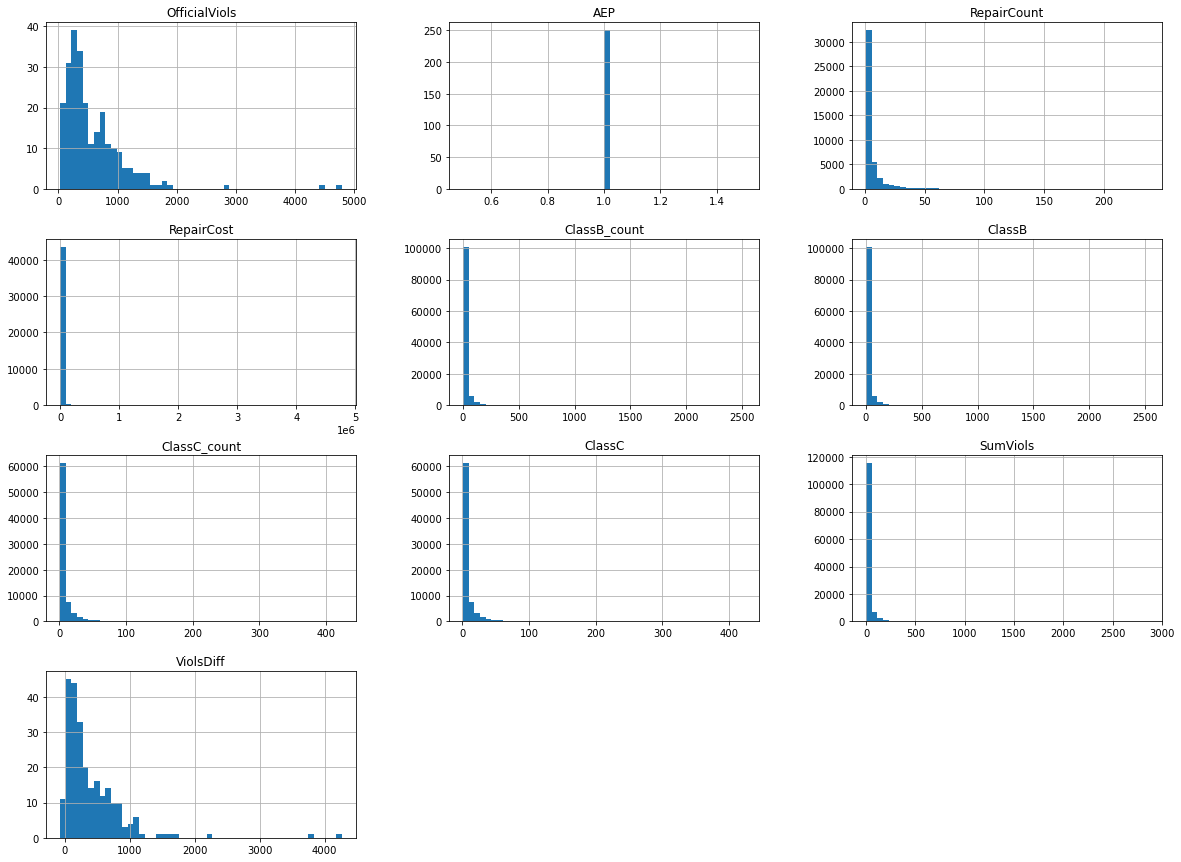

In [80]:
# create new columns to compare the official number of violations to what we have
# just as a sanity check

def violation_comparison():
    global bg
    # sum the violation columns
    bg['SumViols'] = bg[['ClassB','ClassC']].sum(axis=1)
    # compare the violation columns to the official number
    bg['ViolsDiff'] = bg['OfficialViols'] - bg['SumViols']
    print('\nMedian difference between official violation count and our count: ',bg.ViolsDiff.median())
    print('\nShape:\n',bg.shape,'\n\nDescribe:\n',bg.describe(),'\n\nFirst few values:\n',bg.head())
    
    # generate histogram for all of the data columns
    bg.hist(bins=50, figsize=(20,15)) # 20,15
    plt.show()
    
#violation_comparison()

In [81]:
## exporting CSV, for grading

def export_cleaned_data():
    global bg
    # export as CSV for grading purposes
    bg.to_csv(r'''C:\Users\Ale\Documents\CUNY\AdvDataAnal\bg.csv''')
    del bg
#export_cleaned_data()

## Step 1.1: data acquisition

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126378 entries, 0 to 126377
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BBL            126378 non-null  int64  
 1   OfficialViols  250 non-null     float64
 2   AEP            250 non-null     float64
 3   RepairCount    44128 non-null   float64
 4   RepairCost     44128 non-null   float64
 5   ClassB_count   110092 non-null  float64
 6   ClassB         110092 non-null  float64
 7   ClassC_count   77014 non-null   float64
 8   ClassC         77014 non-null   float64
 9   SumViols       126378 non-null  float64
 10  ViolsDiff      250 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 10.6 MB


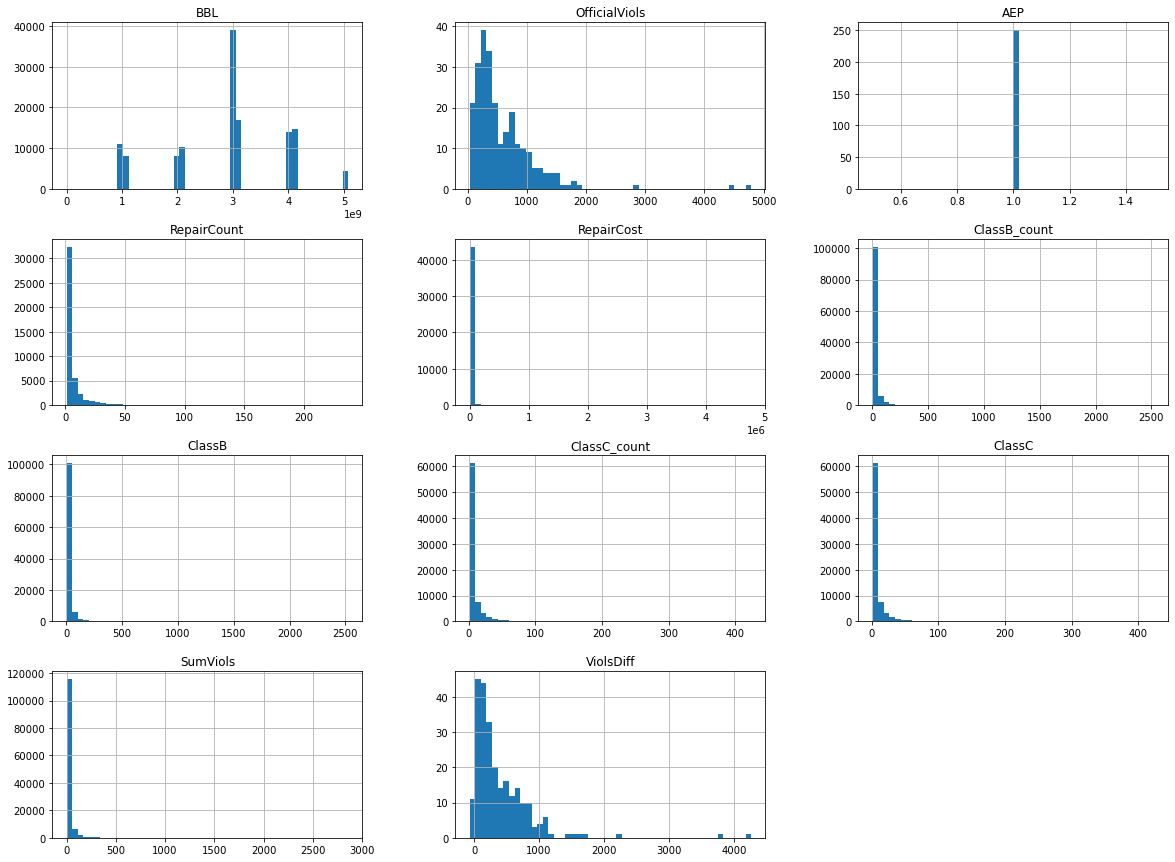

In [109]:
# import CSV, for grading

# 'BBL' here represents a unique building ID, where the first digit is the borough, then the 5-digit block number, then the 4-digit lot number.
# we can see that the data is skewed pretty heavily towards Brooklyn (3) and away from Staten Island (5).
# not sure where the 'BBL.1' column is coming from?? 

# the features will all clearly need to be normalized

bg=0
def import_cleaned_data():
    global bg
    bg = pd.read_csv(r'''bg.csv''', low_memory=False)

import_cleaned_data()
bg.info()

bg.hist(bins=50, figsize=(20,15)) # 20,15
plt.show()

## Step 1.2: divide data into training/testing

In [173]:
# split data into training and testing sets
# not in a function so all variables are global

# recode columns to drop null values
# tried filling them at first but it was really messing with the transformations
#bg['AEP_n'] = bg['AEP'].fillna('NO') # decided to use dummies instead
#bg['RepairCost_n'] = bg['RepairCost'].fillna(0)
#bg['RepairCount_n'] = bg['RepairCount'].fillna(0)
#bg['ClassB_n'] = bg['ClassB'].fillna(0)
#bg['ClassC_n'] = bg['ClassC'].fillna(0)
bg = bg.dropna(axis=0,how='any')
print(bg.head(2000))

data = bg[['RepairCost_n','ClassB_n','ClassC_n','RepairCount_n']]
target = pd.get_dummies(bg['AEP'])
print(data.head())
print(target.head())

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    stratify=target
)

            BBL  OfficialViols  AEP  RepairCount  RepairCost  ClassB_count  \
0    1002050018          186.0  1.0          6.0     6017.00          67.0   
1    1002390011          169.0  1.0          7.0     2286.00          68.0   
3    1003090021          238.0  1.0          4.0     8722.00          75.0   
4    1003100024          108.0  1.0         14.0   105142.37          37.0   
5    1003530060          232.0  1.0          5.0     3134.00         105.0   
..          ...            ...  ...          ...         ...           ...   
245  4157740053          149.0  1.0          6.0    27428.00         173.0   
246  5000050120          370.0  1.0          3.0     2634.00         129.0   
247  5000050124          260.0  1.0          1.0      425.00         190.0   
248  5000200008         1043.0  1.0         13.0     9524.00         559.0   
249  5000460015          108.0  1.0         27.0    70273.04          31.0   

     ClassB  ClassC_count  ClassC  SumViols  ViolsDiff  RepairC

## Step 1.3: explore training set
using df.info() and df.describe()


In [174]:
print('Info: \n',X_train.info(),'\n\nDescribe: \n',X_train.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 210 to 84
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RepairCost_n   186 non-null    float64
 1   ClassB_n       186 non-null    float64
 2   ClassC_n       186 non-null    float64
 3   RepairCount_n  186 non-null    float64
dtypes: float64(4)
memory usage: 7.3 KB
Info: 
 None 

Describe: 
         RepairCost_n    ClassB_n    ClassC_n  RepairCount_n
count     186.000000  186.000000  186.000000     186.000000
mean    18031.314946  135.521505   47.860215      20.397849
std     24161.485071   99.363608   33.718418      19.357876
min       221.000000   11.000000    5.000000       1.000000
25%      5169.000000   78.250000   24.250000       8.000000
50%      9834.625000  107.500000   38.000000      14.000000
75%     23417.250000  157.000000   60.500000      25.750000
max    184694.310000  639.000000  181.000000     138.000000


## Step 1.4: data cleaning

Mostly applied at the beginning.

In [175]:
X_train

,RepairCost_n,ClassB_n,ClassC_n,RepairCount_n
210,28397.75,133.0,38.0,14.0
211,3495.25,66.0,14.0,5.0
186,15229.00,54.0,5.0,5.0
113,34908.65,343.0,159.0,45.0
245,27428.00,173.0,47.0,6.0
...,...,...,...,...
193,2415.00,87.0,34.0,4.0
222,15860.00,135.0,57.0,10.0
11,3330.00,71.0,68.0,6.0
10,3355.00,107.0,27.0,4.0


## Step 1.5: visualize data
using df.hist and plotting.scatter_matrix()

Histogram: 
 [[<AxesSubplot:title={'center':'RepairCost_n'}>
  <AxesSubplot:title={'center':'ClassB_n'}>]
 [<AxesSubplot:title={'center':'ClassC_n'}>
  <AxesSubplot:title={'center':'RepairCount_n'}>]] 

Scatterplot Matrix: 
 [[<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCost_n'>
  <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCost_n'>
  <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCost_n'>
  <AxesSubplot:xlabel='RepairCount_n', ylabel='RepairCost_n'>]
 [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassB_n'>
  <AxesSubplot:xlabel='ClassB_n', ylabel='ClassB_n'>
  <AxesSubplot:xlabel='ClassC_n', ylabel='ClassB_n'>
  <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassB_n'>]
 [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassC_n'>
  <AxesSubplot:xlabel='ClassB_n', ylabel='ClassC_n'>
  <AxesSubplot:xlabel='ClassC_n', ylabel='ClassC_n'>
  <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassC_n'>]
 [<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCount_n'>
  <AxesSubplot:xlabel='ClassB_n

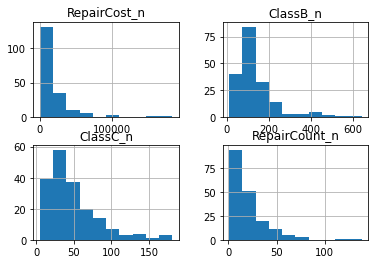

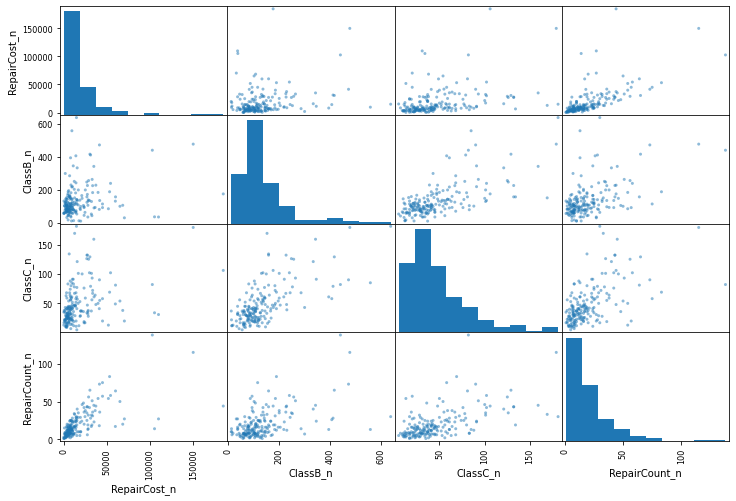

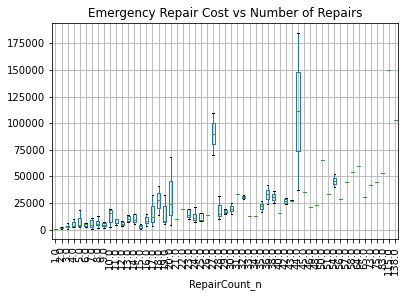

In [176]:
print('Histogram: \n',X_train.hist(),'\n\nScatterplot Matrix: \n',scatter_matrix(X_train, figsize=(12,8)),'\n\n')

gentr_resp_time = X_train.boxplot("RepairCost_n", by='RepairCount_n', showfliers=False)
plt.title('Emergency Repair Cost vs Number of Repairs')
plt.suptitle('')
plt.xticks(rotation=90)
plt.show()

## Step 1.6: apply transformations
then apply hist and scatter_matrix to result

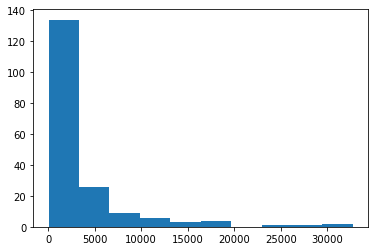

In [187]:
# squaring
plt.hist(X_train['ClassC_n'].values.reshape(-1,1)**2,bins=10)
plt.show()

(array([167.,  12.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,   1.]), array([1.00000e+00, 1.90530e+03, 3.80960e+03, 5.71390e+03, 7.61820e+03,
       9.52250e+03, 1.14268e+04, 1.33311e+04, 1.52354e+04, 1.71397e+04,
       1.90440e+04]), <BarContainer object of 10 artists>)


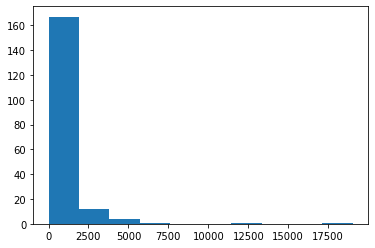

In [178]:
print(plt.hist(X_train['RepairCount_n'].values.reshape(-1,1)**2,bins=10))

(array([153.,  15.,   6.,   1.,   2.,   4.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   2.]),
 array([1.25000000e+02, 3.95432733e+05, 7.90740467e+05, 1.18604820e+06,
        1.58135593e+06, 1.97666367e+06, 2.37197140e+06, 2.76727913e+06,
        3.16258687e+06, 3.55789460e+06, 3.95320233e+06, 4.34851007e+06,
        4.74381780e+06, 5.13912553e+06, 5.53443327e+06, 5.92974100e+06]),
 <BarContainer object of 15 artists>)

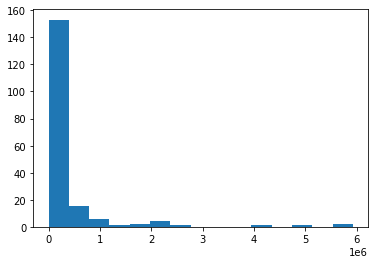

In [195]:
# cubing
plt.hist(X_train['ClassC_n'].values.reshape(-1,1)**3,bins=15)

(array([176.,   5.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([1.00000000e+00, 1.75205733e+05, 3.50410467e+05, 5.25615200e+05,
        7.00819933e+05, 8.76024667e+05, 1.05122940e+06, 1.22643413e+06,
        1.40163887e+06, 1.57684360e+06, 1.75204833e+06, 1.92725307e+06,
        2.10245780e+06, 2.27766253e+06, 2.45286727e+06, 2.62807200e+06]),
 <BarContainer object of 15 artists>)

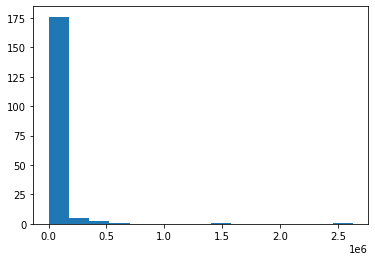

In [192]:
plt.hist(X_train['RepairCount_n'].values.reshape(-1,1)**3,bins=15)

(array([ 2.,  3., 11., 20., 29., 44., 34., 22., 13.,  8.]),
 array([1.60943791, 1.96834382, 2.32724974, 2.68615565, 3.04506156,
        3.40396747, 3.76287338, 4.1217793 , 4.48068521, 4.83959112,
        5.19849703]),
 <BarContainer object of 10 artists>)

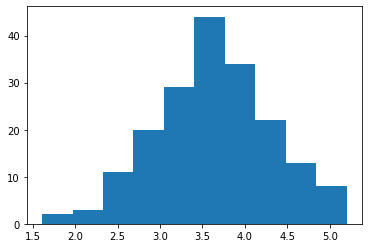

In [196]:
# logarithmic
plt.hist(np.log(X_train['ClassC_n'].values.reshape(-1,1)),bins=10)

(array([ 2.,  5., 11., 25., 30., 47., 31., 23., 10.,  2.]),
 array([0.        , 0.49272537, 0.98545074, 1.47817611, 1.97090147,
        2.46362684, 2.95635221, 3.44907758, 3.94180295, 4.43452832,
        4.92725369]),
 <BarContainer object of 10 artists>)

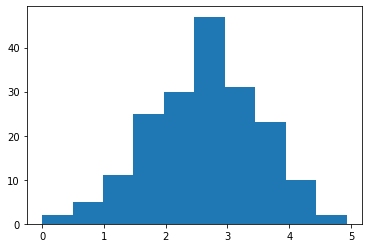

In [197]:
plt.hist(np.log(X_train['RepairCount_n'].values.reshape(-1,1)),bins=10)

(array([184.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.48413159e+02, 4.04856601e+77, 8.09713202e+77, 1.21456980e+78,
        1.61942640e+78, 2.02428300e+78, 2.42913961e+78, 2.83399621e+78,
        3.23885281e+78, 3.64370941e+78, 4.04856601e+78]),
 <BarContainer object of 10 artists>)

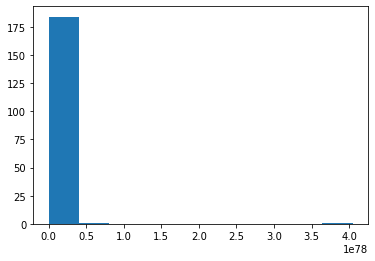

In [198]:
# exponential
plt.hist(np.exp(X_train['ClassC_n'].values.reshape(-1,1)),bins=10)

(array([185.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.71828183e+00, 8.56324762e+58, 1.71264952e+59, 2.56897429e+59,
        3.42529905e+59, 4.28162381e+59, 5.13794857e+59, 5.99427334e+59,
        6.85059810e+59, 7.70692286e+59, 8.56324762e+59]),
 <BarContainer object of 10 artists>)

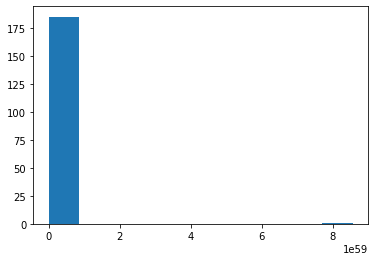

In [199]:
plt.hist(np.exp(X_train['RepairCount_n'].values.reshape(-1,1)),bins=10)

array([[<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='RepairCost_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassB_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassC_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='Repair

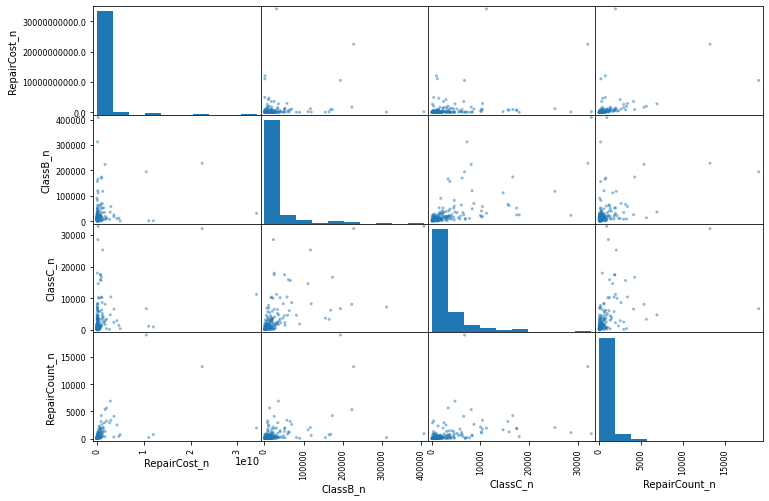

In [201]:
# squared scatter matrix
scatter_matrix(X_train**2, figsize=(12, 8))

array([[<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='RepairCost_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassB_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassC_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='Repair

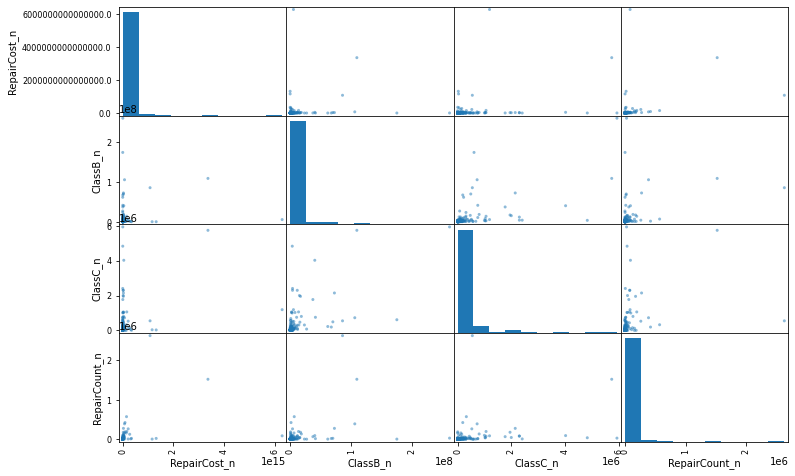

In [202]:
# cubed scatter matrix
scatter_matrix(X_train**3, figsize=(12, 8))

array([[<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCost_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='RepairCost_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassB_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassB_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='ClassC_n'>,
        <AxesSubplot:xlabel='RepairCount_n', ylabel='ClassC_n'>],
       [<AxesSubplot:xlabel='RepairCost_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassB_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='ClassC_n', ylabel='RepairCount_n'>,
        <AxesSubplot:xlabel='Repair

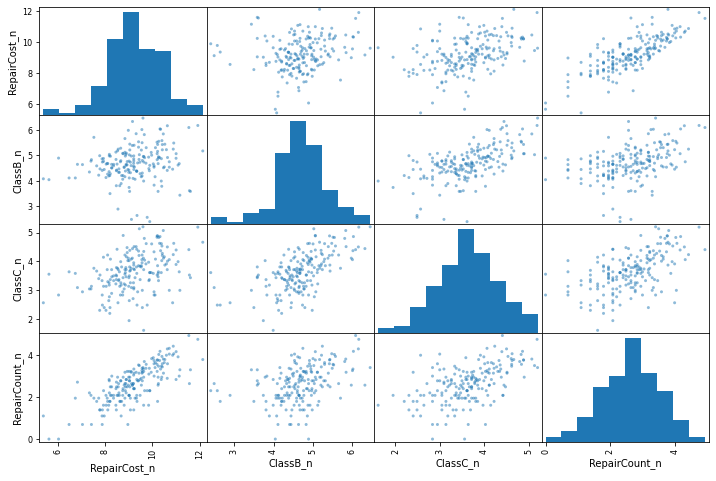

In [205]:
# log scatter matrix
scatter_matrix(np.log(X_train), figsize=(12, 8))

In [207]:
# exp scatter matrix
#scatter_matrix(np.exp(X_train), figsize=(12, 8))
# returns an infinite error

In [182]:
# do we apply these transformations to the other sets as well?

# Project 2

Supervised binary model

In [183]:
# GRID SEARCH !! :D both raw scores and heatmaps 

In [184]:
# confusion matrices 

# Project 3

Unsupervised modeling of the outliers from Project 2 